In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the data
df = pd.read_csv('sample_data.csv')

In [3]:
# Data cleaning and preprocessing
def clean_data(df):
    # Make a copy of the dataframe
    df_clean = df.copy()
    
    # Convert timestamp to datetime format and handle missing values
    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
    
    # Drop rows with missing timestamps for the time-based analysis
    df_time_analysis = df_clean.dropna(subset=['timestamp']).copy()
    
    # Create additional time-related features
    df_time_analysis['day_of_week'] = df_time_analysis['timestamp'].dt.day_name()
    df_time_analysis['month'] = df_time_analysis['timestamp'].dt.month_name()
    df_time_analysis['hour'] = df_time_analysis['timestamp'].dt.hour
    
    # Categorize time of day
    time_of_day_map = {
        8: 'Morning',
        14: 'Afternoon',
        18: 'Evening',
        22: 'Night'
    }
    df_time_analysis['time_of_day'] = df_time_analysis['hour'].map(time_of_day_map)
    
    # For the complete dataset (including rows with missing timestamps)
    # Fill missing transaction_type with the most common value
    df_clean['transaction_type'] = df_clean['transaction_type'].fillna(df_clean['transaction_type'].mode()[0])
    
    return df_clean, df_time_analysis

In [4]:
# Perform data analysis
def analyze_data(df_clean, df_time_analysis):
    # Sales by day of week and time of day
    day_time_sales = df_time_analysis.groupby(['day_of_week', 'time_of_day'])['transaction_amount'].sum().unstack()
    
    # Favorite menu items
    favorite_items = df_clean.groupby('item_name')['quantity'].sum().sort_values(ascending=False)
    
    # Sales by day of week
    day_sales = df_time_analysis.groupby('day_of_week')['transaction_amount'].sum().sort_values(ascending=False)
    
    # Sales by item type
    item_type_sales = df_clean.groupby('item_type')['transaction_amount'].sum()
    
    # Monthly trend
    monthly_sales = df_time_analysis.groupby('month')['transaction_amount'].sum()
    
    # Customer preference (Mr./Mrs.) by time of day
    customer_time_preference = df_time_analysis.groupby(['time_of_day', 'received_by']).size().unstack()
    
    # Calculate profit (assuming 40% profit margin)
    df_clean['profit'] = df_clean['transaction_amount'] * 0.4
    
    return {
        'day_time_sales': day_time_sales,
        'favorite_items': favorite_items,
        'day_sales': day_sales,
        'item_type_sales': item_type_sales,
        'monthly_sales': monthly_sales,
        'customer_time_preference': customer_time_preference
    }

In [5]:
# Build prediction model
import pickle


def build_prediction_model(df_time_analysis):
    # Prepare the data for modeling
    model_df = df_time_analysis.copy()
    
    # One-hot encode categorical features
    categorical_features = ['item_name', 'item_type', 'day_of_week', 'time_of_day', 'received_by']
    numerical_features = ['item_price']
    
    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Define model pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Define features and target
    X = model_df[categorical_features + numerical_features]
    y = model_df['transaction_amount']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model_pipeline.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Evaluation:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

     # Save model
    with open("sales_model.pkl", "wb") as f:
        pickle.dump(model_pipeline, f)
    
    return model_pipeline, categorical_features, numerical_features

In [6]:
# Function to predict sales
def predict_sales(model, item_name, item_type, day_of_week, time_of_day, received_by, item_price, cat_features, num_features):
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'item_name': [item_name],
        'item_type': [item_type],
        'day_of_week': [day_of_week],
        'time_of_day': [time_of_day],
        'received_by': [received_by],
        'item_price': [item_price]
    })
    
    # Make prediction
    predicted_sales = model.predict(input_data[cat_features + num_features])[0]
    predicted_profit = predicted_sales * 0.4
    
    return predicted_sales, predicted_profit

In [7]:
# Visualize the results
def visualize_results(analysis_results):
    # Set up the matplotlib figure
    plt.figure(figsize=(15, 20))
    
    # 1. Sales by day of week and time of day
    plt.subplot(3, 2, 1)
    sns.heatmap(analysis_results['day_time_sales'], annot=True, cmap='YlGnBu', fmt='.0f')
    plt.title('Sales by Day of Week and Time of Day')
    
    # 2. Favorite menu items
    plt.subplot(3, 2, 2)
    analysis_results['favorite_items'].head(10).plot(kind='bar')
    plt.title('Top 10 Favorite Menu Items by Quantity Sold')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    
    # 3. Sales by day of week
    plt.subplot(3, 2, 3)
    analysis_results['day_sales'].plot(kind='bar')
    plt.title('Total Sales by Day of Week')
    plt.ylabel('Sales Amount')
    plt.xticks(rotation=45)
    
    # 4. Sales by item type
    plt.subplot(3, 2, 4)
    analysis_results['item_type_sales'].plot(kind='pie', autopct='%1.1f%%')
    plt.title('Sales Distribution by Item Type')
    
    # 5. Monthly trend
    plt.subplot(3, 2, 5)
    analysis_results['monthly_sales'].plot(kind='line', marker='o')
    plt.title('Monthly Sales Trend')
    plt.ylabel('Sales Amount')
    plt.xticks(rotation=45)
    
    # 6. Customer preference by time of day
    plt.subplot(3, 2, 6)
    analysis_results['customer_time_preference'].plot(kind='bar', stacked=True)
    plt.title('Customer Preference by Time of Day')
    plt.ylabel('Number of Orders')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('sales_analysis_results.png')
    plt.close()

In [8]:
# Main function
def main():
    print("Loading and cleaning data...")
    df_clean, df_time_analysis = clean_data(df)
    
    print("\nPerforming data analysis...")
    analysis_results = analyze_data(df_clean, df_time_analysis)
    
    print("\nSales by Day of Week and Time of Day:")
    print(analysis_results['day_time_sales'])
    
    print("\nTop 5 Favorite Menu Items:")
    print(analysis_results['favorite_items'].head(5))
    
    print("\nSales by Day of Week:")
    print(analysis_results['day_sales'])
    
    print("\nBuilding prediction model...")
    model, cat_features, num_features = build_prediction_model(df_time_analysis)
    
    print("\nVisualizing results...")
    visualize_results(analysis_results)
    
    print("\nExample of sales prediction:")
    predicted_sales, predicted_profit = predict_sales(
        model, 
        'Vadapav', 
        'Fastfood', 
        'Monday', 
        'Evening', 
        'Mr.', 
        20, 
        cat_features, 
        num_features
    )
    
    print(f"Predicted sales for Vadapav on Monday evening: Rs. {predicted_sales:.2f}")
    print(f"Predicted profit: Rs. {predicted_profit:.2f}")
    
    # Interactive prediction
    def interactive_prediction():
        print("\n--- Sales Prediction Tool ---")
        print("Available menu items: Vadapav, Panipuri, Aalopuri, Frankie, Sandwich, Cold coffee, Sugarcane juice")
        print("Available item types: Fastfood, Beverages")
        print("Available days: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday")
        print("Available times: Morning, Afternoon, Evening, Night")
        print("Available customer types: Mr., Mrs.")
        
        item_name = input("Enter menu item: ")
        item_type = input("Enter item type (Fastfood/Beverages): ")
        day_of_week = input("Enter day of week: ")
        time_of_day = input("Enter time of day (Morning/Afternoon/Evening/Night): ")
        received_by = input("Enter customer type (Mr./Mrs.): ")
        
        # Get item price from the dataset
        item_price = df[df['item_name'] == item_name]['item_price'].iloc[0] if len(df[df['item_name'] == item_name]) > 0 else 0
        
        if item_price == 0:
            print("Item not found in database. Please enter the price manually.")
            item_price = float(input("Enter item price: "))
        
        predicted_sales, predicted_profit = predict_sales(
            model, 
            item_name, 
            item_type, 
            day_of_week, 
            time_of_day, 
            received_by, 
            item_price, 
            cat_features, 
            num_features
        )
        
        print(f"\nPredicted sales for {item_name} on {day_of_week} {time_of_day.lower()}: Rs. {predicted_sales:.2f}")
        print(f"Predicted profit: Rs. {predicted_profit:.2f}")
        
        another = input("\nMake another prediction? (y/n): ")
        if another.lower() == 'y':
            interactive_prediction()
    
    run_interactive = input("\nWould you like to make predictions interactively? (y/n): ")
    if run_interactive.lower() == 'y':
        interactive_prediction()
    
    print("\nAnalysis complete! Check 'sales_analysis_results.png' for visualizations.")

Loading and cleaning data...

Performing data analysis...

Sales by Day of Week and Time of Day:
time_of_day  Afternoon  Evening  Morning  Night
day_of_week                                    
Friday            5210     8095     7820   7295
Monday           10660     4820     8245   9910
Saturday          7090     7080     6430   9325
Sunday            6380     8795    11630   9690
Thursday         10260     7820     7820   7890
Tuesday           7290     6900     5150   8250
Wednesday         9455     8845     6635   9715

Top 5 Favorite Menu Items:
item_name
Cold coffee        1361
Sugarcane juice    1278
Panipuri           1226
Frankie            1150
Sandwich           1097
Name: quantity, dtype: int64

Sales by Day of Week:
day_of_week
Sunday       36495
Wednesday    34650
Thursday     33790
Monday       33635
Saturday     29925
Friday       28420
Tuesday      27590
Name: transaction_amount, dtype: int64

Building prediction model...
Model Evaluation:
Mean Squared Error: 25344.69


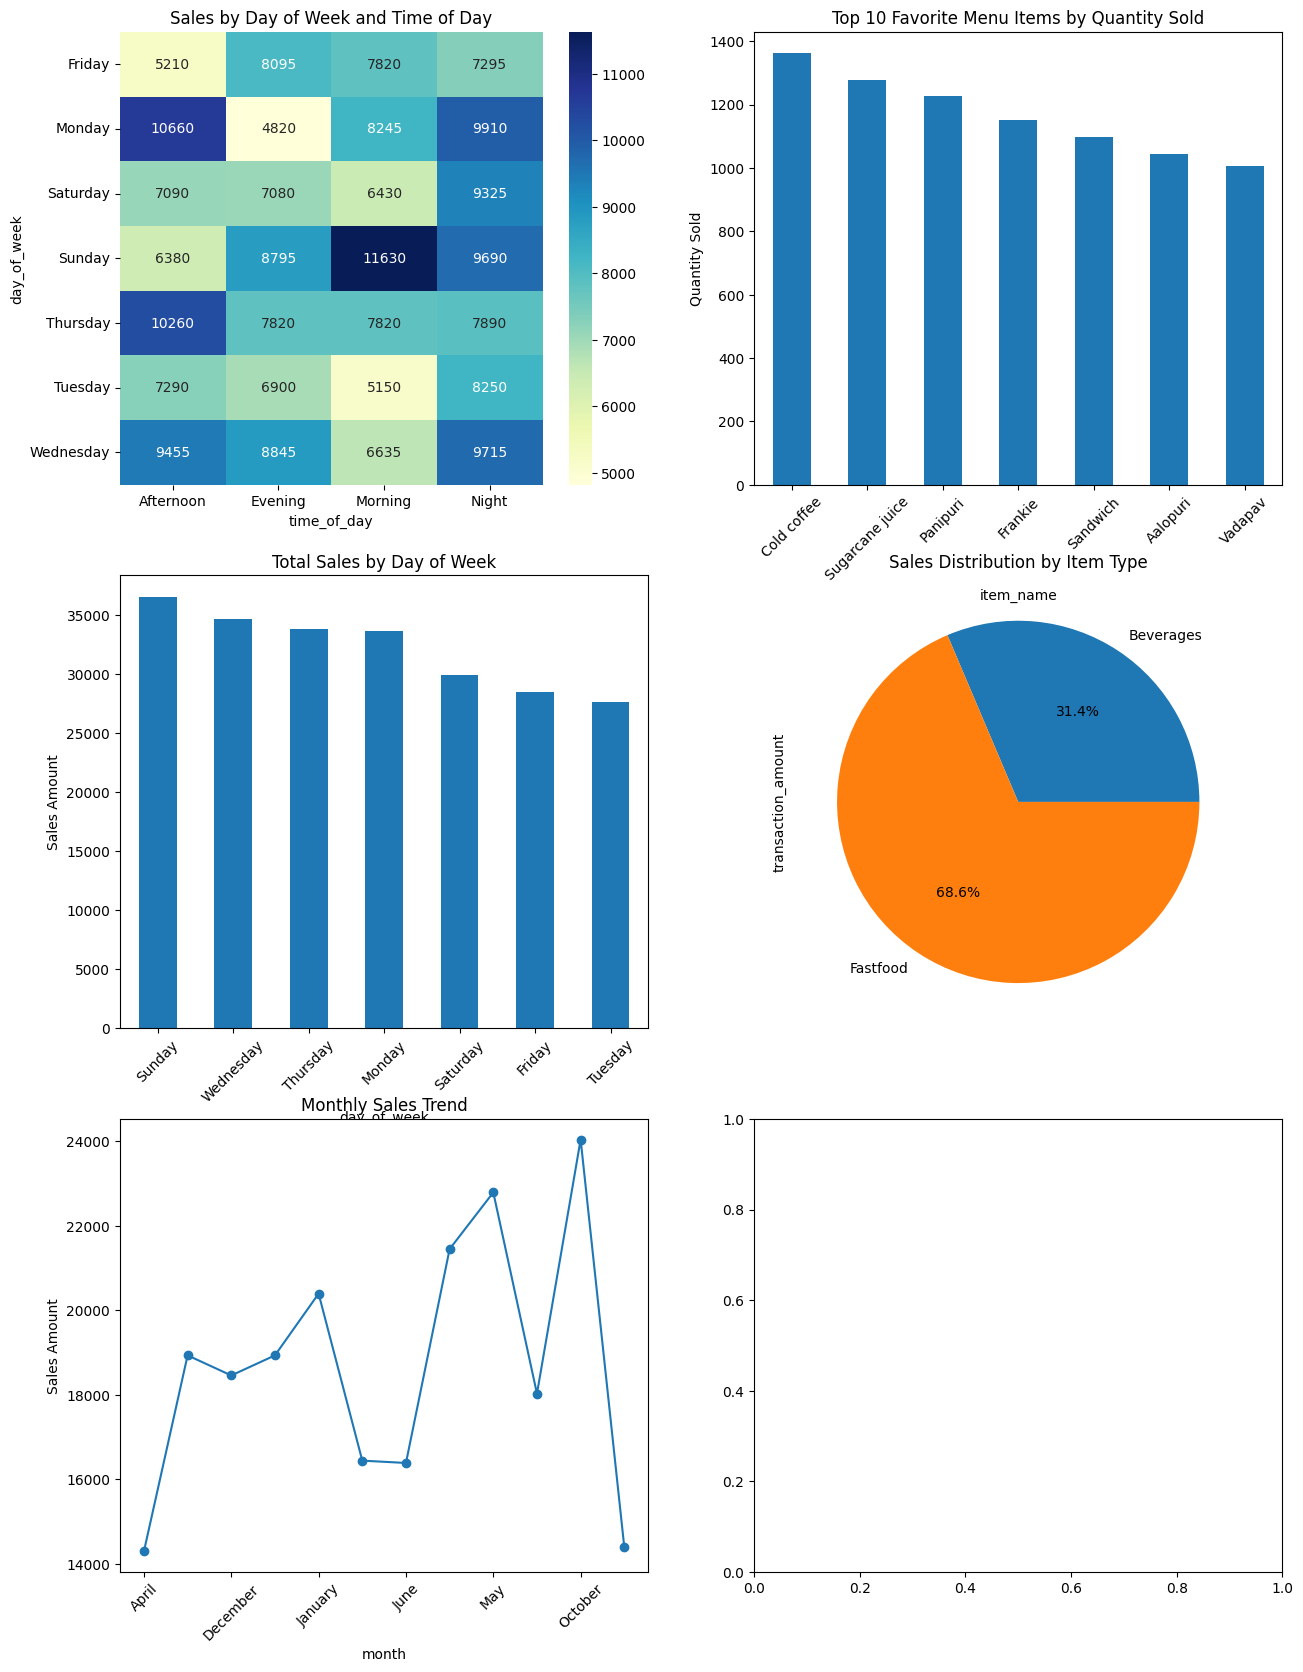

In [9]:
if __name__ == "__main__":
    main()